In [1]:
from tensorflow.keras.optimizers import Adam


In [2]:
import os
import sys
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


###!NOTE using keras function flow_from_directory does not work because image are tif
#### however datagenerator seems to work... 


img_height=256*1
img_width=256*1



data_dir='Data/Dataset2-Durum Wheat Video Images'



subdir=os.listdir(data_dir)

#removed subdir with mixt stuff
for sub in list(subdir):
    if 'Mixture' in sub:
        subdir.remove(sub)

print(subdir)

Df=pd.DataFrame()
count=0
for i in range(len(subdir)):
    fpath =data_dir+'/'+subdir[i]
    for file in os.listdir(fpath):
        label=subdir[i].split(' ')[2]
        row=pd.DataFrame(data={"filename": fpath+'/'+file, "class": label},index=[count])
        Df=pd.concat([Df,row])

        count+=1
Df.head()




#cut dataframe into train, eval and test 
Df_train,Df_nottrain=train_test_split(Df,test_size=0.2) # (1-test_size)*100=80% for training
Df_eval,Df_test=train_test_split(Df_nottrain,test_size=0.7)


#reference unlabeled and labeld mixture picture


['1-Images from Vitreous Durum Wheat', '2-Images from Starchy Durum Wheat', '3-Images from Foreign Matters']


In [3]:
#reference unlabeled and labeld mixture picture

subdir=os.listdir(data_dir)

#removed subdir with mixt stuff
for sub in list(subdir):
    if 'Mixture' not in sub:
        subdir.remove(sub)

print(subdir)

Df_mix=pd.DataFrame()
count=0
fpath_unlabeled =data_dir+'/'+subdir[0]
fpath_labeled =data_dir+'/'+subdir[1]

frames=os.listdir(fpath_unlabeled)
for i in range(len(frames)):
    file_unlabeled=fpath_unlabeled+'/'+frames[i]
    file_labeled  =fpath_labeled+'/'+frames[i]
    row=pd.DataFrame(data={'unlabeled':file_unlabeled,'labeled':file_labeled},index=[i])   
    Df_mix=pd.concat([Df_mix,row])



['4-Images from Mixture of All Durum Wheat and Foreign Matters', '5-Images form Mixture of All Durum Wheat and Foreign Matters (Labeled)']


In [4]:
#work fine but every wheat has to be differentiate before, which could be problematic for 'live' action
from tensorflow.keras.backend import clear_session

clear_session() #clear keras session


############################## U-NET for instance detection and classification
from keras.layers import Input,Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, BatchNormalization, Activation, concatenate
import tensorflow as tf

def double_conv(x,n_filter):
    # 1st Conv2D then ReLU activation
    x1 = Conv2D(filters=n_filter, #dimension of output space=number of filter in the convolution
                kernel_size=3,  #convolution  window size
                kernel_initializer = 'he_normal', #normal distribution centered on 0
                padding = 'same'
                )(x)
    #x1=BatchNormalization(x1)
    x1=Activation('relu')(x1)
   
    # Conv2D then ReLU activation
    x2 = Conv2D(filters=n_filter, #dimension of output space=number of filter in the convolution
                kernel_size=3,  #convolution  window size
                kernel_initializer = 'he_normal', #normal distribution centered on 0
                padding = 'same',
                )(x1)
    #x2=BatchNormalization(x2)
    x2=Activation('relu')(x2)    
    return x2


def down(x,pct_dropout,n_filter):
    conved=double_conv(x,n_filter=n_filter)
    downed=MaxPooling2D(pool_size=(2,2),padding='valid')(x)
    downed=Dropout(pct_dropout)(downed)
    return conved, downed 


def up(x,feature_map,pct_dropout,n_filter):
    #Conv2DTranspose : going in the opposite direction of a normal convolution, 
    xT=Conv2DTranspose(filters=n_filter,
                    kernel_size=3,
                    strides=2,#  #this is 'opposite' of maxpool 2*2
                    #kernel_initializer='he_normal', not sure here
                    padding='same'
                    #activation='linear'#'relu'
                    )(x)
    
    concat_result=concatenate([xT,feature_map])#bon ordre?
    conved=double_conv(concat_result,n_filter=n_filter)
    out=Dropout(pct_dropout)(conved)
    return out 


pct_dropout=0.2

def make_Unet_model(img_width,img_height,nfilt):

    input=Input(shape=(img_width,img_height,3))#

    ####successive downscaling aka encoding
    conv_1,downed=down(input,pct_dropout,n_filter=nfilt)
    conv_2,downed=down(downed,pct_dropout,n_filter=nfilt*2)
    conv_3,downed=down(downed,pct_dropout,n_filter=nfilt*4)
    conv_4,downed=down(downed,pct_dropout,n_filter=nfilt*8)

    #transition from  encoder to decoder, aka model bottleneck
    transition=double_conv(downed,n_filter=nfilt*16)

    #successive upscaling aka decoding
    up4=up(transition,conv_4,pct_dropout,n_filter=nfilt*8)
    up3=up(up4,conv_3,pct_dropout,n_filter=nfilt*4)
    up2=up(up3,conv_2,pct_dropout,n_filter=nfilt*2)
    up1=up(up2,conv_1,pct_dropout,n_filter=nfilt)



    result=Conv2D( filters=3+1, #0=background here!   #here filters= number of class to predict
                    kernel_size=2,#was1, 2 is a test,
                    padding="same",
                    activation = 'softmax'
                    )(up1)


    Unet_model = tf.keras.Model(inputs=[input],
                                outputs=[result],
                                name="U-Net")

    return Unet_model

#tf.keras.utils.plot_model(Unet_model, show_shapes=True)

Unet_model=make_Unet_model(img_width,img_height,64)
Unet_model.summary()


####Unet conv2d output give x,y,nclass
#### -> mask need to be     x,y,nclass -> cateogrize mask according to last dimension


### batchnormalization give error:
#A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to an int

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64, 3) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64, 3) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32, 3) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32, 3) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16, 3) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16, 3) │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     28,672 │ dropout_3[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 16, 16,    │          0 │ conv2d_8[0][0]    │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     14,336 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ activation_8[0][… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ activation_6[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  4,719,104 │ activation_9[0][… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 32, 32,    │          0 │ conv2d_7[0][0]  

 Total params: 28,299,268 (107.95 MB)

 Trainable params: 28,299,268 (107.95 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.ops.image import resize 
import keras.utils as utils
import cv2
from tensorflow.keras.utils import to_categorical


labeldic={'Foreign': 1, 'Starchy': 2, 'Vitreous': 3}



In [6]:

def get_img_mask(Df):

    X=np.zeros((len(Df),img_width,img_height,3),dtype = np.float64)
    Y=np.zeros((len(Df),img_width,img_height,4),dtype = np.uint8)

    for i in range(len(Df)):
        filename=Df.iloc[i]['filename']
        label=Df.iloc[i]['class']

        img=utils.load_img(filename)
        img_array=utils.img_to_array(img)
        img_array=img_array#.astype(int)

        # convert to grayscale
        #convert image to 8bits, needed to gray conversion
        img_array_8b=cv2.convertScaleAbs(img_array)
        img_gray = cv2.cvtColor(img_array_8b,cv2.COLOR_RGB2GRAY)

        # threshold
        ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY)

        # get contours
        result = img_array_8b.copy()
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        clean_contours=[]
        for contour in contours:
            area=cv2.contourArea(contour)
            if area> 600: #number of pixel i think
                clean_contours.append(contour)



        emptymask=np.zeros((img_gray.shape[0],img_gray.shape[1],1)) #if the extra dimension is removed, resize does not work!
        mask = cv2.drawContours(emptymask,
                                clean_contours,
                                -1,
                                color= labeldic[label],
                                thickness=cv2.FILLED)
        #mask=mask#.astype('uint8')
        #print(label, dic[label])

        ############resize 
        resized=resize(img_array,
                    size=(img_width,img_height),
                    fill_value=0,
                    data_format='channels_last',
                    interpolation='bilinear'
                    )
        img_resized=resized.numpy() # i dont want tensor


        resized=resize(mask,
                    size=(img_width,img_height),
                    fill_value=0,
                    data_format='channels_last',
                    interpolation='nearest'#'bilinear'
                    )
        mask_resized=resized.numpy() # i dont want tensor
        mask_resized=to_categorical(np.squeeze(mask_resized,axis=-1),num_classes=4)#Unet output is one layer=one class

        X[i]=img_resized /255#image rescaling to be between 0 and 1
        Y[i]=mask_resized

        #Y=to_categorical(Y[:,:,:,0],num_classes=4)#Unet output is one layerr=one class

    return X,Y


IMG,MASK=get_img_mask(Df_train)



filename    Data/Dataset2-Durum Wheat Video Images/3-Image...
class                                                 Foreign
Name: 171, dtype: object
expected categories in mask [0 1]
existing categories in mask [0 1]
expected color: red
if bad borders in right figure, visualization errors!


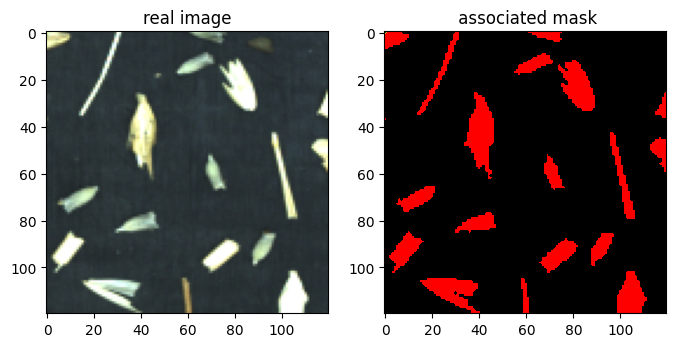

In [7]:
#############A test to verify if mask is correctly computed
import random
from matplotlib import colors

# Create the custom colormap
discrete_colors = ['black', 'red', 'orange', 'green']
mycmap = colors.ListedColormap(discrete_colors)
#layer 0: devrait etre : 1 partout sauf la ou des objet,
#layer 1: devrait etre 1 pour Foreign, 0 ailleurs,
#layer 2: devrait etre 1 pour STarchy 0 ailleurs
#layer 3: devrait etre 1 pour Vitreous 0 ailleurs


#i=10
i=random.randint(0,IMG.shape[0]-1)#try some number to check mask


# some index for visualization
idx_color=labeldic[Df_train.iloc[i]['class']]
ymin=75
ymax=ymin+120
xmin=110
xmax=xmin+120


#plt.imshow(IMG[i,ymin:ymax,xmin:xmax])


#print('mask in channel ' +str(idx_color) +' is :')
#z=MASK[i,ymin:ymax,xmin:xmax,idx_color]#.astype(int)
#print(z)
mask=np.argmax(MASK,axis=-1)#.astype(int)


#print(mask[i,ymin:ymax,xmin:xmax]) #
#print(MASK[i,ymin:ymax,xmin:xmax,3]) #

print(Df_train.iloc[i])
print('expected categories in mask [0 '+str(idx_color)+']') #0 is background
print('existing categories in mask', np.unique(mask[i]))
print('expected color:',discrete_colors [idx_color] )

mask2=mask[i,ymin:ymax,xmin:xmax]
mask2[0,0]=3# a trick to enforce mycmap color for vizualisation
fig,ax=plt.subplots(1,2,figsize=(8,16))
ax[0].imshow(IMG[i,ymin:ymax,xmin:xmax])
ax[1].imshow(mask2,cmap=mycmap)
ax[0].set_title('real image')
ax[1].set_title(' associated mask')
#np.unique(mask[i,ymin:ymax,xmin:xmax])


print('if bad borders in right figure, visualization errors!')

In [8]:
Df_train

,filename,class
161,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
192,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
141,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
40,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous
158,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
...,...,...
25,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous
75,Data/Dataset2-Durum Wheat Video Images/2-Image...,Starchy
118,Data/Dataset2-Durum Wheat Video Images/2-Image...,Starchy
180,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign


In [ ]:
from keras.metrics import IoU, MeanIoU # IoU should increase will training
import keras
from tensorflow.keras.backend import clear_session


####try already done network
# import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
# import segmentation_models as sm
# BACKBONE = 'resnet34'
# Unet_model=sm.Unet(BACKBONE, encoder_weights='imagenet')



clear_session()

Batch_size=12*2

data_train=get_img_mask(Df_train)
data_eval=get_img_mask(Df_eval)



Unet_model=make_Unet_model(img_width,img_height,64)

#https://github.com/qubvel/segmentation_models?tab=readme-ov-file#examples
#BACKBONE = 'resnet34'
#Unet_model=sm.Unet(BACKBONE, encoder_weights='imagenet',classes=4,activation='softmax')
#failed

##explanation for image metrics
###https://medium.com/mastering-data-science/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
wei={0:10.0,1:3.0,2:3.0,3:3.0}

def weightedLoss(originalLossFunc, weightsList):
    '''not my function! found it on the web'''
    
    def lossFunc(true, pred):
        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = keras.ops.argmax(true, axis=-1) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [keras.ops.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [keras.ops.cast(x, tf.keras.backend.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc


opt = Adam(learning_rate=0.0005)
Unet_model.compile( optimizer=opt,
                    loss=keras.losses.categorical_crossentropy, # a probabilty loss (entropy=chaos)
                    #loss=keras.losses.dice, #see https://arxiv.org/abs/1707.03237
                    #loss=keras.losses.tversky, #seee https://arxiv.org/abs/1706.05721
                    #loss=keras.losses.categorical_focal_crossentropy,#see https://arxiv.org/pdf/1708.02002
                    #loss=weightedLoss(keras.losses.categorical_crossentropy,wei),
                    metrics=['accuracy',
                             IoU(num_classes=4,target_class_ids=[1]), # for a given class
                             MeanIoU(num_classes=4)]# all class combined
                    )
           



Epoch 1/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 139s 18s/step - accuracy: 0.7284 - io_u: 0.0000e+00 - loss: 1.0461 - mean_io_u: 0.3750 - val_accuracy: 0.8824 - val_io_u: 0.0000e+00 - val_loss: 0.7575 - val_mean_io_u: 0.3750
Epoch 2/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 134s 19s/step - accuracy: 0.8808 - io_u: 0.0000e+00 - loss: 0.6090 - mean_io_u: 0.3750 - val_accuracy: 0.8863 - val_io_u: 0.0000e+00 - val_loss: 0.3547 - val_mean_io_u: 0.3750
Epoch 3/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 167s 24s/step - accuracy: 0.9041 - io_u: 0.0086 - loss: 0.3000 - mean_io_u: 0.3801 - val_accuracy: 0.8834 - val_io_u: 4.3279e-04 - val_loss: 0.2731 - val_mean_io_u: 0.3753
Epoch 4/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 122s 17s/step - accuracy: 0.9116 - io_u: 0.1442 - loss: 0.2160 - mean_io_u: 0.4611 - val_accuracy: 0.8910 - val_io_u: 0.0629 - val_loss: 0.2034 - val_mean_io_u: 0.4124
Epoch 5/6
7/7 ━━━━━━━━━━━━━━━━━━━━ 119s 17s/step - accuracy: 0.9161 - io_u: 0.2785 - loss: 0.1886 - mean_io_u: 0.5423 - val_accuracy: 0.8995 - val_io_u: 0.0684 - val_lo

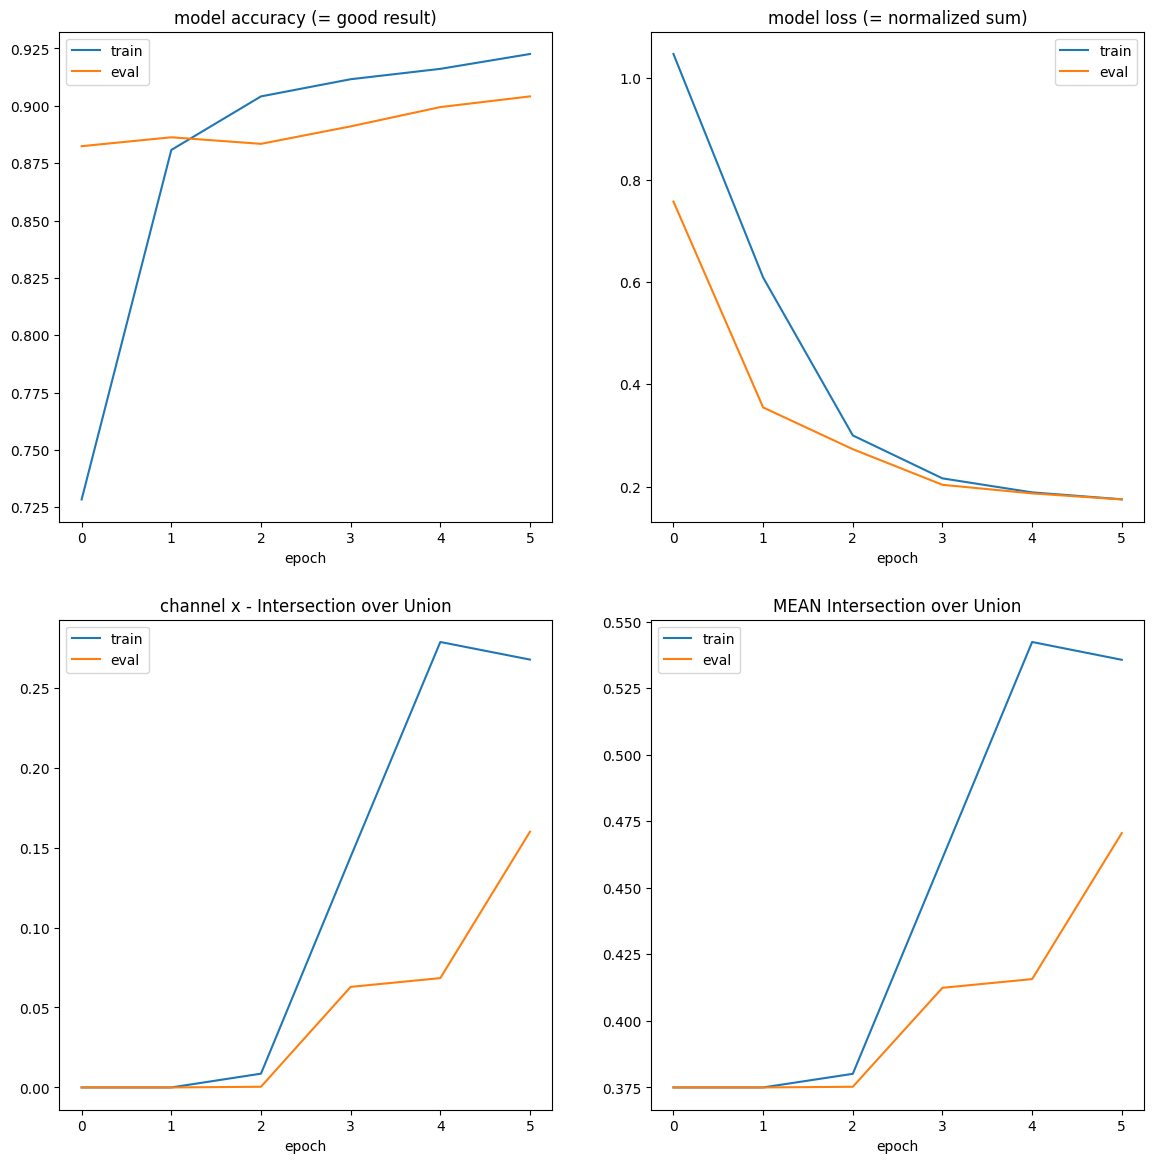

In [10]:
#tf.config.run_functions_eagerly(True)


history = Unet_model.fit(x=data_train[0],y=data_train[1],
                    validation_data=data_eval,
                    epochs=6,#12
                    batch_size=Batch_size,
                    #class_weight=wei# classe weight ok only if 1D data
                    ) 




fig,ax=plt.subplots(2,2,figsize=(14,14))
ax[0,0].plot(history.history['accuracy'])
ax[0,0].plot(history.history['val_accuracy'])
ax[0,0].set_title('model accuracy (= good result)')
ax[0,0].set_ylabel('')
ax[0,0].set_xlabel('epoch')
ax[0,0].legend(['train', 'eval'])


ax[0,1].plot(history.history['loss'])
ax[0,1].plot(history.history['val_loss'])
ax[0,1].set_title('model loss (= normalized sum)')
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('epoch')
ax[0,1].legend(['train', 'eval'])


ax[1,0].plot(history.history['io_u'])
ax[1,0].plot(history.history['val_io_u'])
ax[1,0].set_title('channel x - Intersection over Union')
ax[1,0].set_ylabel('')
ax[1,0].set_xlabel('epoch')
ax[1,0].legend(['train', 'eval'])

ax[1,1].plot(history.history['mean_io_u'])
ax[1,1].plot(history.history['val_mean_io_u'])
ax[1,1].set_title('MEAN Intersection over Union')
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('epoch')
ax[1,1].legend(['train', 'eval'])


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step


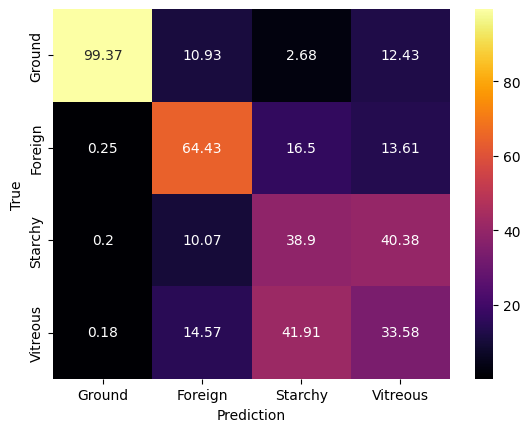

accuracy=92.84
              precision    recall  f1-score   support

      Ground       0.99      0.99      0.99   1618912
     Foreign       0.64      0.44      0.52     58874
     Starchy       0.39      0.90      0.54     75347
    Vitreous       0.34      0.00      0.01     81875

    accuracy                           0.93   1835008
   macro avg       0.59      0.58      0.52   1835008
weighted avg       0.93      0.93      0.92   1835008


 
 



In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns


def show_confusion(y_test,y_predic,classes,titl):
    '''
    Show confusion matrix and classification error for a given prediction (= classification here)
    '''

    cm = confusion_matrix(y_test, y_predic)
    cm=cm / cm.sum(axis=0)*100#normalisation to get proba
    cm=cm.astype('float')
    cm2=np.array(["%.2f" % w for w in cm.reshape(cm.size)])
    cm2=cm2.reshape(cm.shape).astype(float)       

    ax=sns.heatmap(cm2,annot=True,cmap='inferno',fmt='g',xticklabels=classes,yticklabels=classes)
    ax.set(xlabel='Prediction',ylabel='True')
    ax.set(title=titl)

    acc='{:.2f}'.format(accuracy_score(y_test,y_predic)*100 )  
    report=classification_report(y_test, y_predic,target_names=classes,output_dict=False)

    plt.show()
    print('accuracy='+acc)
    print(report)
    print('\n \n \n')



im,mask=get_img_mask(Df_test)
mask=np.argmax(mask,axis=-1)

#make prediction on unseen images
proba=Unet_model.predict(im,batch_size=Batch_size)
prediction=np.argmax(proba,axis=-1)

show_confusion(mask.flatten(),
               prediction.flatten(),
               classes=['Ground','Foreign','Starchy','Vitreous'],
               titl=''
               )


#% NOT OK???, sum is not 100, neither rows or columns!!!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


filename    Data/Dataset2-Durum Wheat Video Images/1-Image...
class                                                Vitreous
Name: 53, dtype: object
expected color: green
expected values: (array([0, 3], dtype=int64), array([58926,  6610], dtype=int64))
predicted values: (array([0, 1, 2, 3], dtype=int64), array([58835,   613,  6069,    19], dtype=int64))


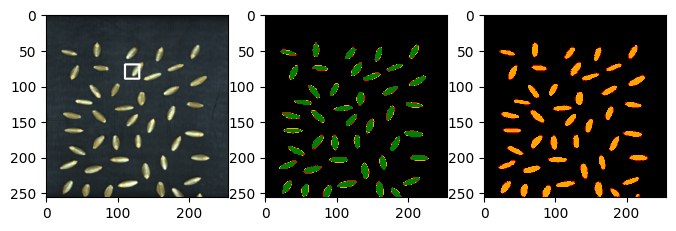

In [31]:
ymin=70
ymax=ymin+20
xmin=110
xmax=xmin+20

#foreign=red
#starchy=orange
#vitreous=green

i=random.randint(0,im.shape[0]-1)#try some number

myimg=im[i].copy()#cv2.convertScaleAbs(mask[i])
cv2.rectangle(myimg,(xmin,ymin),(xmax,ymax),(120,120,120),2)

print(Df_test.iloc[i])
idx_color=labeldic[Df_test.iloc[i]['class']]
print('expected color:',discrete_colors [idx_color] )


mask[i,0,0]=3# a trick to enforce mycmap color for vizualisation
prediction[i,0,0]=3# a trick to enforce mycmap color for vizualisation
fig,ax=plt.subplots(1,3,figsize=(8,16))
ax[0].imshow(myimg)
ax[1].imshow(mask[i],cmap=mycmap)
ax[2].imshow(prediction[i],cmap=mycmap)
#fig.colorbar(p,ax=ax[1],orientation='horizontal')

mask[i,0,0]=0
prediction[i,0,0]=0
print('expected values:',np.unique(mask[i],return_counts=True))
print('predicted values:',np.unique(prediction[i],return_counts=True))

In [32]:
print('mask \n',mask[i,ymin:ymax,xmin:xmax])
print('\n')
print('prediction \n',prediction[i,ymin:ymax,xmin:xmax])


mask 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


prediction 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'predicted')

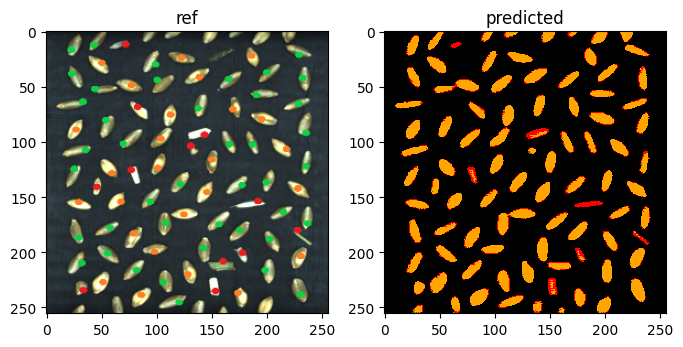

In [33]:

#### Test for images with mulitples class, reference is annotated by researcher


def get_image(Df,columnfile):

    IM=np.zeros((len(Df),img_width,img_height,3),dtype = np.float64)

    for i in range(len(Df)):
        filename=Df[columnfile].iloc[i]

        img=utils.load_img(filename)
        img_array=utils.img_to_array(img)
        img_array=img_array.astype(int)

        resized=resize(img_array,
                    size=(img_width,img_height),
                    fill_value=0,
                    data_format='channels_last',
                    interpolation='bilinear'
                    )
        img_resized=resized.numpy() # i dont want tensor


        IM[i]=img_resized/255

    return IM


IM_mixed_unlabeled=get_image(Df_mix,'unlabeled')
IM_mixed_labeled=get_image(Df_mix,columnfile='labeled')


proba=Unet_model.predict(IM_mixed_unlabeled,batch_size=Batch_size)
prediction=np.argmax(proba,axis=-1)

i=random.randint(0,IM_mixed_labeled.shape[0]-1)#try some number to check mask


IM_mixed_labeled[i,0,0]=3# a trick to enforce mycmap color for vizualisation
prediction[i,0,0]=3# a trick to enforce mycmap color for vizualisation
fig,ax=plt.subplots(1,2,figsize=(8,16))
ax[0].imshow(IM_mixed_labeled[i])
ax[1].imshow(prediction[i],cmap=mycmap)
ax[0].set_title('ref')
ax[1].set_title('predicted')

#foreign=red
#starchy=orange
#vitreous=green



[[2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


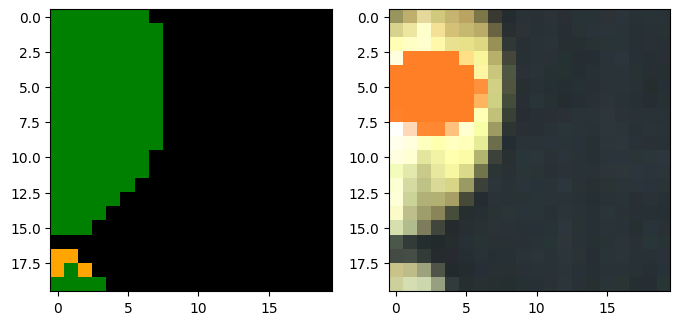

In [34]:
fig,ax=plt.subplots(1,2,figsize=(8,16))
ax[0].imshow(prediction[i,ymin:ymax,xmin:xmax],cmap=mycmap)
ax[1].imshow(IM_mixed_labeled[i,ymin:ymax,xmin:xmax])

print(prediction[i,ymin:ymax,xmin:xmax])

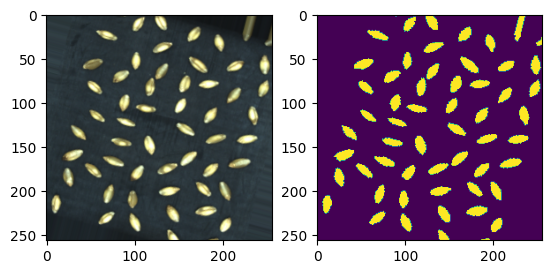

In [43]:
################################################################################################################
######################################### MAYBE NOT ENOUGH DATA???  generate image##############################


from keras_preprocessing.image import ImageDataGenerator

# datagen=ImageDataGenerator(rescale=1/255)
# train_datagen=datagen.flow_from_dataframe(dataframe=Df_train,
#                                           target_size=(img_width,img_height),
#                                           class_mode='sparse', 
#                                           shuffle=True, # so order in filename is not important
#                                           batch_size=12,
#                                           rotation_range=10,
#                                           )

def make_datagen(Df):

    IMG,MASK=get_img_mask(Df)

    img_datagen=ImageDataGenerator(rotation_range=20) # rescale not neeed as already done im get_img_mask
    mask_datagen=ImageDataGenerator(rotation_range=20) #rescale not needed as mask is categorical
    seed=42

    img_datagen.fit(IMG,seed=seed,augment=True)
    mask_datagen.fit(MASK,seed=seed,augment=True)

    x=img_datagen.flow(IMG,batch_size=Batch_size,seed=seed)
    y=mask_datagen.flow(MASK,batch_size=Batch_size,seed=seed)

    return zip(x, y)


train_datagen=make_datagen(Df_train)
eval_datagen=make_datagen(Df_eval)


A,b=next(train_datagen)

fig,ax=plt.subplots(1,2)
ax[0].imshow(A[0])
ax[1].imshow(np.argmax(b[0],-1))



In [44]:
clear_session()

Unet_model=make_Unet_model(img_width,img_height,64)

opt = Adam(learning_rate=0.0005)
Unet_model.compile( optimizer=opt,
                    loss=keras.losses.categorical_crossentropy, # a probabilty loss (entropy=chaos)
                    #loss=keras.losses.dice, #see https://arxiv.org/abs/1707.03237
                    #loss=keras.losses.tversky, #seee https://arxiv.org/abs/1706.05721
                    #loss=keras.losses.categorical_focal_crossentropy,#see https://arxiv.org/pdf/1708.02002
                    #loss=weightedLoss(keras.losses.categorical_crossentropy,wei),
                    metrics=['accuracy',
                             IoU(num_classes=4,target_class_ids=[1]), # for a given class
                             MeanIoU(num_classes=4)]# all class combined
                    )
           
history = Unet_model.fit(*train_datagen,
                    validation_data=eval_datagen,
                    epochs=10
                    ) 



MemoryError: Unable to allocate 18.0 MiB for an array with shape (24, 256, 256, 3) and data type float32

In [ ]:

im,mask=get_img_mask(Df_test)
mask=np.argmax(mask,axis=-1)

#make prediction on unseen images
proba=Unet_model.predict(im,batch_size=Batch_size)
prediction=np.argmax(proba,axis=-1)

show_confusion(mask.flatten(),
               prediction.flatten(),
               classes=['Ground','Foreign','Starchy','Vitreous'],
               titl=''
               )


In [ ]:

IMG,MASK=get_img_mask(Df_test)


batch=IMG
y_proba=Unet_model.predict(batch)
y_pred=np.argmax(y_proba,axis=-1) 




fig,ax=plt.subplots(1,2,figsize=(8,16))

i=2
ax[0].imshow(batch[i])
ax[1].imshow(y_pred[i])